# Chebyshev Methods Via the Fast Cosine Transform

The key to making Chebyshev spectral methods efficient for large $N$ (and in multiple dimensions) is the [fast Fourier transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform).
The Fourier series of a function $f(x)$ sampled on $2N+1$ equidistant points in $[-\pi, \pi)$ can be expressed as 
$$
f(\frac{j\pi}{N}) = \sum_{k=-N}^{N} c_k e^{i\pi j k / N}, \qquad j = -N, -N+1, \dots, N-1, N,
$$

where $c_k$ are the Fourier coefficients, and the frequencies $k$ range from $-N$ to $N$. The Fast Fourier Transform (FFT) is an efficient algorithm to compute the discrete Fourier transform (DFT), which maps the function values $f(x_j)$ to the Fourier coefficients $c_k$. By exploiting symmetries of the terms $ e^{i\pi j k / N}$, the FFT reduces the computational complexity of the transformation from $O(N^2)$ to $O(N \log N)$.

When applied to Chebyshev spectral methods, the essential idea is to use the relationship between Chebyshev polynomials and cosine, namely that
$$T_k(x) = \cos(k \arccos(x)).$$

This essentially implies that the Chebyshev series is a cosine series with a change of coordinates. Further, recall that the points of the Chebyshev-Lobatto grid are of the form:
$$x_j = -\cos\frac{j \pi}{N}, \qquad j = 0, \dots, N$$
Hence,
$$T_k(x_j) = \cos\frac{j k \pi}{N}.$$
Therefore, we see that the $N+1$ term Chebyshev series evaluated on $x_j$ is equivaluent to the $2N+1$ term Fourier series evaluated at $\frac{j\pi}{N}$ where $c_k$ are real. Moreover, since $c_k$ are real, we can gain one more symmetry to reduce the cost of the FFT by a factor of two. The modified algorithm is the fast cosine transform.

There are four types of cosine transforms. Type I is the one associated with the Lobatto grid--this transform is its own inverse (upto a constant scaling factor). Type II is for midpoint grid, and its inverse is the Type III (these are __the__ DCT and IDCT, respctively). See [Scipy's documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html) for a more detailed description of these three types as well as a description of the Type IV transform.

The cosine transform of interest for Chebyshev methods is Type I. We use this transform to convert function values on the Chebyshev-Lobatto grid to the coefficients of the Chebyshev series in $O(N \log N)$ operations. We can then evaluate derivatives using the recurrence formula for the derivative. Let $c_k$ be the Chebyshev coefficients for a function $f$, then the coefficients $d_k$ of the derivative $f'$ are given by
$$d_k = d_{k+2} + 2(k+1)c_{k+1}.$$
Once we evaluate $d_k$ we can convert back to function values using the cosine transform again. The fast derivative algorithm runs in $O(N \log N)$ time and requires $O(N)$ memory. A huge improvement over the matrix multiplication method (for large $N$) which runs in $O(N^2)$ and requires $O(N^2)$ storage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct

from cheb import *

In [2]:
def fast_derivative(f, L=2):
  """
  Computes the derivative of f on the Chebyshev grid using the FFT.
  
  f: function values on the Chebyshev grid
  L: is the length of the interval over which f is defined.
  """

  N = len(f) - 1

  # Compute Chebyshev coefficients: DCT
  c = dct(f, type=1, norm='forward')
  
  c[0] /= 2
  c[N] /= 2

  # compute coefficients of the derivative
  d = np.zeros(N + 1)

  d[N] = 0.0
  d[N - 1] = 2 * N * c[N]
  for k in range(N-2, 0, -1):
    d[k] = d[k + 2] + 2 * (k + 1) * c[k + 1]
  d[0] = c[1] + 0.5 * d[2]
  
  # compute derivative values on grid: IDCT
  d[0] *= 2
  d[N] *= 2

  df = dct(d, type=1, norm='backward')
  
  df *= -2 / L # change of variable rescaling

  return df

## Example

Consider the function
$$f(x) = e^{\cos(x + s * x^3)}.$$
Its exact derivative is given by:
$$f'(x) = -(1 + 3s x^2) \sin(x + s x^3) e^{\cos(x + s x^3)}.$$

This function is highly oscillatory and requires many points to approximate accurately.

error ~ 1.90e-10


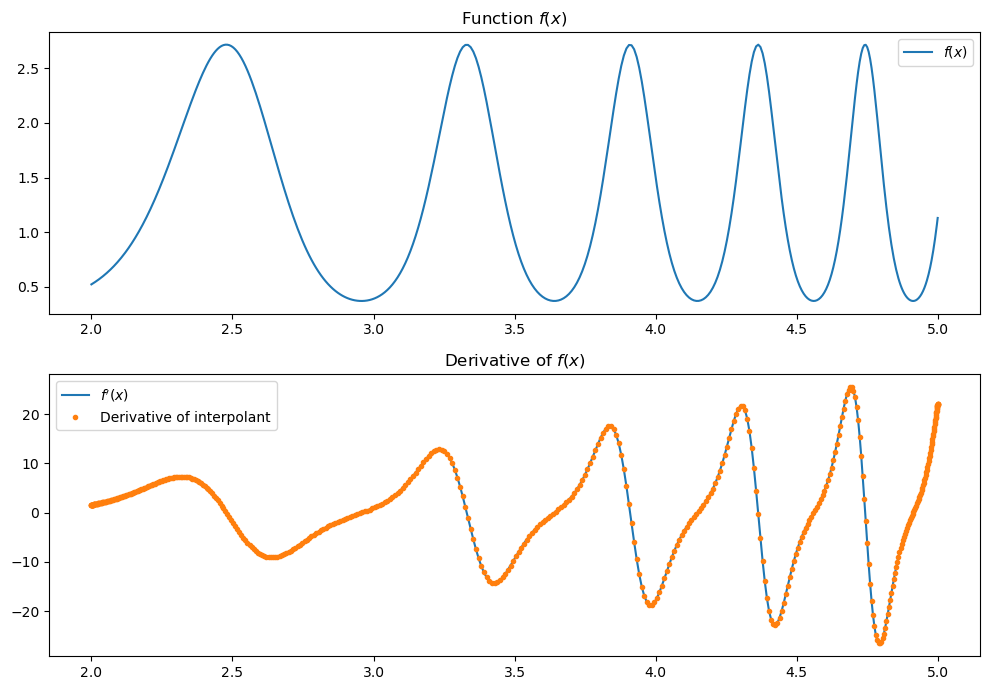

In [3]:
n = 500

a = 2
b = 5

x = chebyshev_lobatto_grid(a, b, n)

s = 0.25
y = np.exp( np.cos(x + s * x**3) )
dy = -(1 + 3 * s * x**2) * np.sin(x + s * x**3) * y

Dy = fast_derivative(y, L=b-a)

e = np.linalg.norm(dy - Dy, np.inf)
print("error ~ %.2e"%e)

fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# First subplot
axs[0].plot(x, y, '-', label='$f(x)$')
axs[0].legend()
axs[0].set_title('Function $f(x)$')

# Second subplot
axs[1].plot(x, dy, '-', label='$f\'(x)$')
axs[1].plot(x, Dy, '.', label='Derivative of interpolant')
axs[1].legend()
axs[1].set_title('Derivative of $f(x)$')

plt.tight_layout()
plt.show()

## Derivatives in 2D

On a tensor product grid of Chebyshev-Lobatto points we can use the tensor product structure to compute the derivative efficiently.

In [4]:
def fast_Dx(f, Lx=2):
  """
  Computes the partial derivative of f with respect to y on a 2D grid using the FFT.
  Assumes that f is defined on a tensor product grid of Chebyshev-Lobatto points,
  and that f[i, j] = f(x[i], y[j]). When using meshgrid, this is achieved with the `indexing='ij'` option.
  """
  Nx = f.shape[0] - 1

  # Compute Chebyshev coefficients: DCT
  c = dct(f, type=1, norm='forward', axis=0)

  c[0, :] /= 2
  c[Nx, :] /= 2

  # compute coefficients of the derivative
  dx = np.zeros_like(f)

  dx[Nx, :] = 0.0
  dx[Nx - 1, :] = 2 * Nx * c[Nx, :]
  for k in range(Nx-2, 0, -1):
    dx[k, :] = dx[k + 2, :] + 2 * (k + 1) * c[k + 1, :]
  dx[0, :] = c[1, :] + 0.5 * dx[2, :]

  # compute derivative values on grid: IDCT
  dx[0, :] *= 2
  dx[Nx, :] *= 2

  dfx = dct(dx, type=1, norm='backward', axis=0)
  dfx *= -2 / Lx # change of variable rescaling

  return dfx

def fast_Dy(f, Ly=2):
  """
  Computes the partial derivative of f with respect to x on a 2D grid using the FFT.
  Assumes that f is defined on a tensor product grid of Chebyshev-Lobatto points,
  and that f[i, j] = f(x[i], y[j]). When using meshgrid, this is achieved with the `indexing='ij'` option.
  """
  Ny = f.shape[1] - 1

  # Compute Chebyshev coefficients: DCT
  c = dct(f, type=1, norm='forward', axis=1)

  c[:, 0] /= 2
  c[:, Ny] /= 2

  # compute coefficients of the derivative
  dy = np.zeros_like(f)

  dy[:, Ny] = 0.0
  dy[:, Ny - 1] = 2 * Ny * c[:, Ny]
  for k in range(Ny-2, 0, -1):
    dy[:, k] = dy[:, k + 2] + 2 * (k + 1) * c[:, k + 1]
  dy[:, 0] = c[:, 1] + 0.5 * dy[:, 2]

  # compute derivative values on grid: IDCT
  dy[:, 0] *= 2
  dy[:, Ny] *= 2

  dfy = dct(dy, type=1, norm='backward', axis=1)
  dfy *= -2 / Ly # change of variable rescaling

  return dfy

def fast_gradient(f, Lx=2, Ly=2):
  """
  Computes the gradient of f on a 2D grid using the FFT.
  Assumes that f is defined on a tensor product grid of Chebyshev-Lobatto points,
  and that f[i, j] = f(x[i], y[j]). When using meshgrid, this is achieved with the `indexing='ij'` option.
  """
  return fast_Dx(f, Lx), fast_Dy(f, Ly)


## Example

Consider the function
$$f(x, y) = \sin(5 x - 4 y^2).$$
Its partial derivatives are
$$f_x = 5 \cos(5 x - 4 y^2), \qquad f_y = -8 y \cos(5x - 4y^2).$$

error ~ 8.01e-11


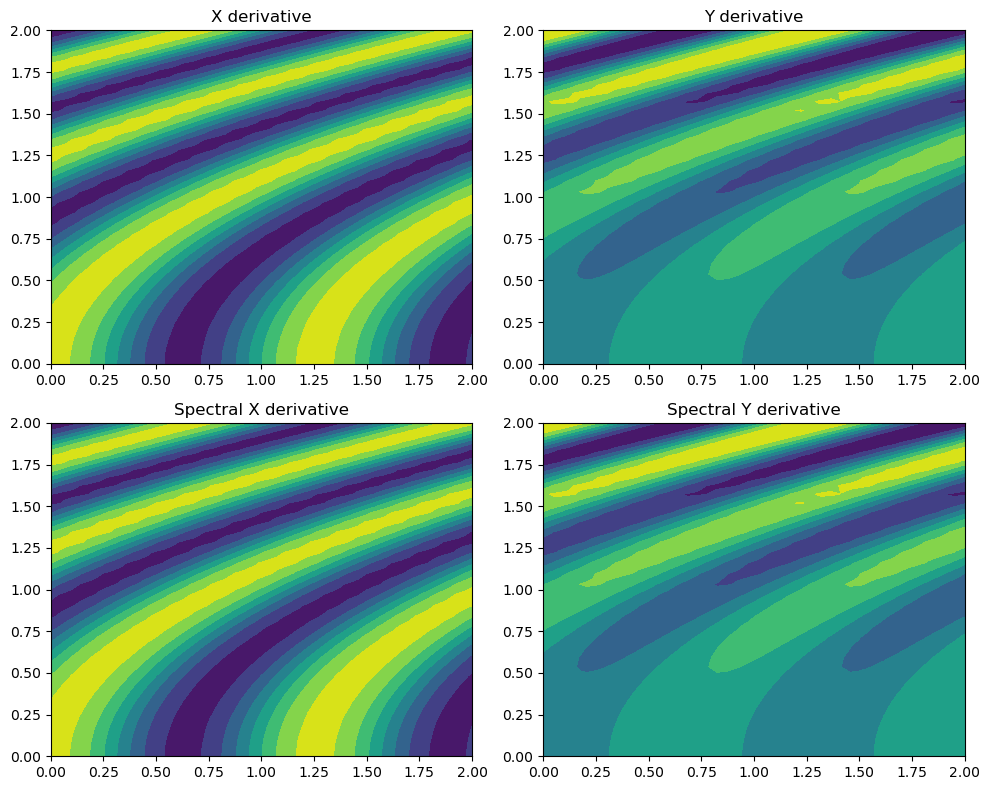

In [5]:
nx = 64
ny = 50
x = chebyshev_lobatto_grid(0, 2, nx)
y = chebyshev_lobatto_grid(0, 2, ny)

X, Y = np.meshgrid(x, y, indexing='ij') # indexing `ij` means F[i, j] = f(x[i], y[j])

f = lambda x, y: np.sin(5 * x - 4 * y**2)
fx = lambda x, y: 5 * np.cos(5 * x - 4 * y**2)
fy = lambda x, y: -8 * y * np.cos(5 * x - 4 * y**2)

F = f(X, Y)
dfx = fx(X, Y)
dfy = fy(X, Y)

Dfx, Dfy = fast_gradient(F, Lx=2, Ly=2)

error = np.linalg.norm(dfx - Dfx, np.inf) + np.linalg.norm(dfy - Dfy, np.inf)

print("error ~ %.2e"%error)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0,0].contourf(X, Y, dfx, cmap='viridis')
axs[0,0].set_title('X derivative')

axs[0,1].contourf(X, Y, dfy, cmap='viridis')
axs[0,1].set_title('Y derivative')

axs[1,0].contourf(X, Y, Dfx, cmap='viridis')
axs[1,0].set_title('Spectral X derivative')

axs[1,1].contourf(X, Y, Dfy, cmap='viridis')
axs[1,1].set_title('Spectral Y derivative')

plt.tight_layout()
plt.show()